<a href="https://colab.research.google.com/github/datascientist-hist/Bitcoin-Price/blob/main/HW1/HomeWork_1_Giuseppe_Pulino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 Giuseppe Pulino
**Task :**
Classify 8 different objects,with a dataset of 16000 images ,200 per class

**Problem :**
The dataset that has been provided to us has a problem with the zero classes.While the images of the other class have always either different backgrounds or the same but with some changes ,the images of the  zero class share the same background but different from the other class  leading a simply  net to learn the bias

**Solutions :**
To overcome the problem I have tried two different approaches :

- **1) Approach**  In the first one, I preprocessed  the  images  applying a mask to the images of zero class .The aim of the mask was to remove the background using the bounding box to force the net to focus only on the object.In this approach I used a simply pretrained CNN Resnet50

- **2) Approach** In the second one, I have simply used an object detection net called Faster R-CNN without preprocessing the images 

# Conclusions

Both approaches yielded valid results,with the first one sometimes I was able to get an accuracy greater than 93% , the benefit of this approach is of course the speed of training compared to Faster R-CNN, 2 minutes against 20 minutes, the disadvantage instead is that I used the bounding box to train only a classifier even if I could have added a regressor and furthermore only one object per image can be recognized 

The second approach have provided more stable results with an accuracy almost always above 95% , the advantage to use this method is that we  have an object dector and even powerful.

The highest score presents in the leaderboard has been produced by Faster R-CNN

# Importing Libraries

In [ ]:
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download aiunict-2023

In [ ]:
! unzip aiunict-2023

In [ ]:
pip install captum

In [ ]:
dest_dir = ""
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
#from engine import train_one_epoch, evaluate
#import utils
#import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from numpy import asarray



import captum
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel
from captum.attr import visualization as viz
import time

from torchvision.models import resnet50, ResNet50_Weights
# Define an optimizier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision


# Creating Custom Dataset

In [ ]:
class UnictImg(Dataset):
    def __init__(self, dset_dir, train=True,mask=False,res_bb_perc=0, transforms=None):
        
        self.split = "train" if train else "test"
        self.dset_dir = Path(dset_dir)/self.split
        self.transforms = transforms
        self.res_bb_perc=res_bb_perc
        self.mask=mask
        self.files = []
        self.df_bb=pd.DataFrame()
        self.df_bb=pd.read_csv(dest_dir+"train.csv")
        folders = sorted(os.listdir(self.dset_dir))
        self.file=folders
        if self.split=="train" :         
            for folder in folders:
                class_idx= folders.index(folder)
                folder_dir = self.dset_dir/folder
                files = os.listdir(folder_dir)
                if(class_idx==0):
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":True} for x in files]
                    if(mask):
                        self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":True} for x in files]
                else:
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False} for x in files]
                    if(mask):
                        self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False} for x in files]

        else:
            self.files+=[self.dset_dir/file for file in folders]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        
        if self.split == "train":
            
            item = self.files[i]
            file = item['file']
            class_idx=item['class']
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            # recover bounding boxes
            name_file_img=item['mask']
            bb=self.df_bb[self.df_bb["image"]==name_file_img]
          
            # resize bounding boxes
            xmin=int(bb["x1"])+1
            ymin=int(bb["y1"])+1
            xmax=int(bb["x2"])-1
            ymax=int(bb["y2"])-1
            res_bb_perc=self.res_bb_perc
            boxes = [[xmin+((xmax-xmin)*res_bb_perc), 
                      ymin+((ymax-ymin)*res_bb_perc), 
                      xmax-((xmax-xmin)*res_bb_perc), 
                      ymax-((ymax-ymin)*res_bb_perc)]]           
           
                    
            labels = torch.tensor(item['class'],dtype=torch.int64)
            labels=labels.unsqueeze(0)
                                    
            # applying transformations            
            sample = {'image' : img_res,
                      'bboxes' : boxes,
                      'labels' : labels}
               
            sample = self.transforms(**sample)
            target = {}
            target["boxes"] =torch.tensor(sample['bboxes'],dtype=torch.int64)
            target["labels"] = torch.tensor(sample['labels'],dtype=torch.int64)
            img_res = sample['image']
            
            if(self.mask and item['flag']):
                
                bb=target['boxes'][0]
                #creating masked image
                mask=torch.rand(3,224,224)
                mask[0:3,bb[1]:bb[3],bb[0]:bb[2]]= img_res[0:3,bb[1]:bb[3],bb[0]:bb[2]]
                img_res=mask
                
            if(self.mask):
                target["labels"] =  target["labels"]-1
                class_idx-=1
               
            return img_res, target,class_idx
        else:
            file = self.files[i]
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            sample = {'image': img_res}
            sample = self.transforms(**sample)
            image = sample['image']
           
            return image,self.file[i]
        

    



# Setting Cuda

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Defining Function to Plot Image

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target=None,train=True):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    if(train):
        fig, a = plt.subplots(1,1)
        fig.set_size_inches(5,5)
        a.imshow(img)
        for box in (target['boxes'].cpu()):
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

            # Draw the bounding box on top of the image
            a.add_patch(rect)
        plt.show()
    else:
        fig, a = plt.subplots(1,1)
        fig.set_size_inches(5,5)
        a.imshow(img)
        plt.show()
    #print(target['labels'])
    #print(target['boxes'])
    
# plotting the image with bboxes. Feel free to change the index
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Pre-Processing Approach

## Data Augmentations 1° Approach

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(1),
        A.Resize(224,224),
        A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2, rotate_limit=45, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(224,224),
        ToTensorV2(p=1.0)
    ])

## Data Loader 1° Approach

In [ ]:
dataset_resnet = UnictImg(dest_dir, train=True,mask=True,res_bb_perc=0.05, transforms= get_train_transform())

train_data_loader_resnet = DataLoader(
    dataset_resnet,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

Area = tensor(10404)
class 0


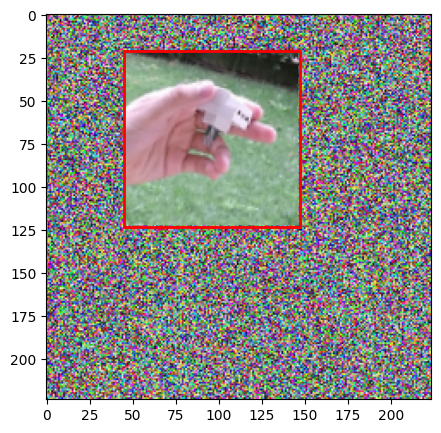

In [ ]:
img, target,idx = dataset_resnet[36]
bb=target['boxes'][0]
print('Area = '+str((bb[2]-bb[0])*(bb[3]-bb[1])))
print('class '+ str(idx))
img=torch_to_pil(img)
plot_img_bbox(img, target)

## Defining ResNet50

In [ ]:
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model_resnet.fc.in_features
# Parameters of newly constructed modules have requires_grad=True by default
model_resnet.fc = nn.Linear(num_ftrs, 8)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_resnet.parameters(), lr=0.005, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


In [ ]:
num_epochs = 5  #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    start_time_epoch = time.time() #(for showing time)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_resnet.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs,tar,labels) in enumerate(train_data_loader_resnet):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_resnet.__len__()
    epoch_acc = running_corrects / dataset_resnet.__len__() * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    #    ' Testing Phase '
   

Epoch 0 running
[Train #0] Loss: 0.4113 Acc: 86.8438% Time: 43.8802s
Epoch 1 running
[Train #1] Loss: 0.0453 Acc: 99.1562% Time: 76.6756s
Epoch 2 running
[Train #2] Loss: 0.0230 Acc: 99.4062% Time: 112.1208s
Epoch 3 running
[Train #3] Loss: 0.0328 Acc: 99.1875% Time: 148.8075s
Epoch 4 running
[Train #4] Loss: 0.0197 Acc: 99.4688% Time: 183.1296s


## XAI with GradCam

In [ ]:
test_dataset = UnictImg(dest_dir, train=False, transforms= get_test_transform())

## Defining function XAI

In [ ]:
def XAI(ds,index,train=False):
    if(train):
        img, tar,idx = ds[index]
    else:
         img, name_file = ds[index]
    model_resnet.eval()
    with torch.no_grad():
        inputs = img.unsqueeze(0).to(device)
        outputs = model_resnet(inputs)
    _, preds = torch.max(outputs, 1)
        
    print(int(preds))
    layer_gradcam = LayerGradCam(model_resnet, model_resnet.layer4[2].conv3)
    attributions_lgc = layer_gradcam.attribute(inputs, target=preds)

    #_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                            # sign="all",
                            # title="Layer 4 Block 1 Conv 2")
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, inputs.shape[2:])

    print(attributions_lgc.shape)
    print(upsamp_attr_lgc.shape)
    print(inputs.shape)

    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

## Testing the modelTest Set

0
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


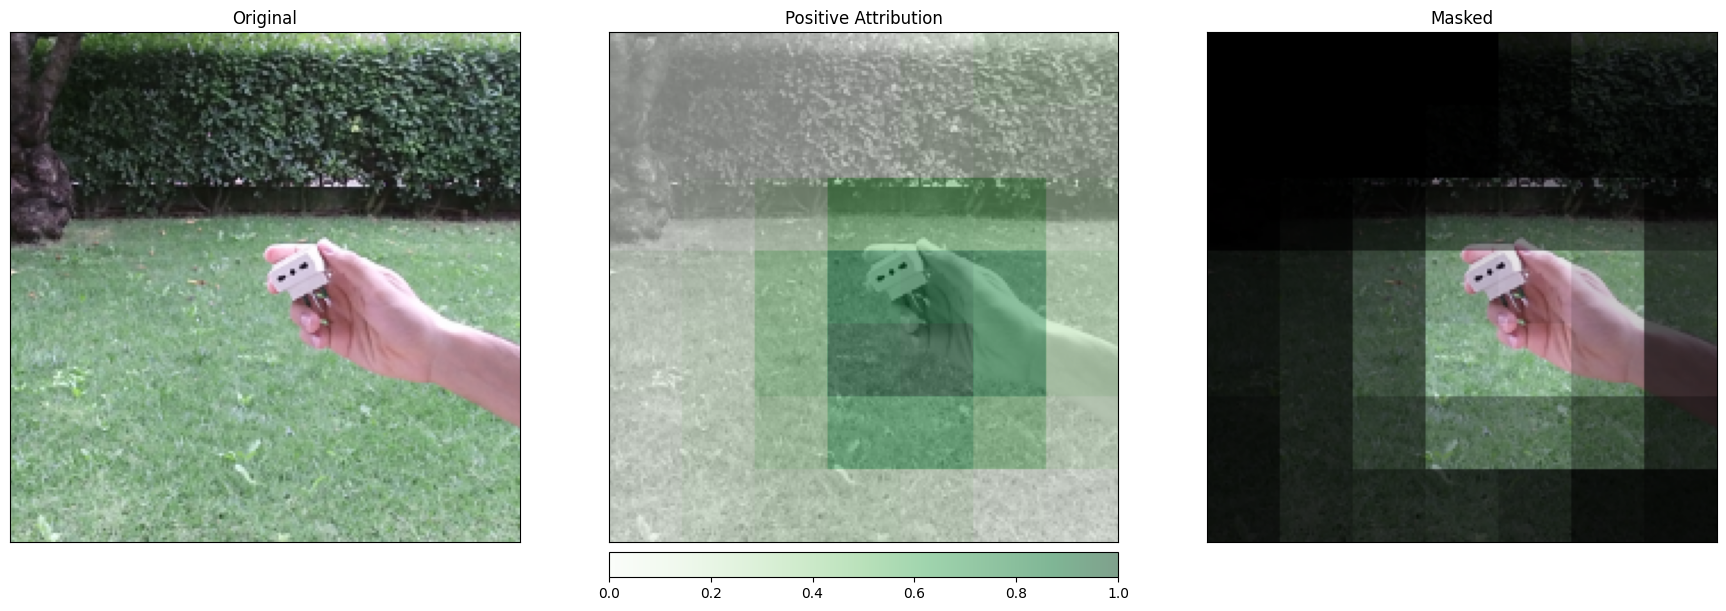

In [ ]:
XAI(test_dataset,1)#21socke6#0#196

## Testing the model- Test Set

1
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


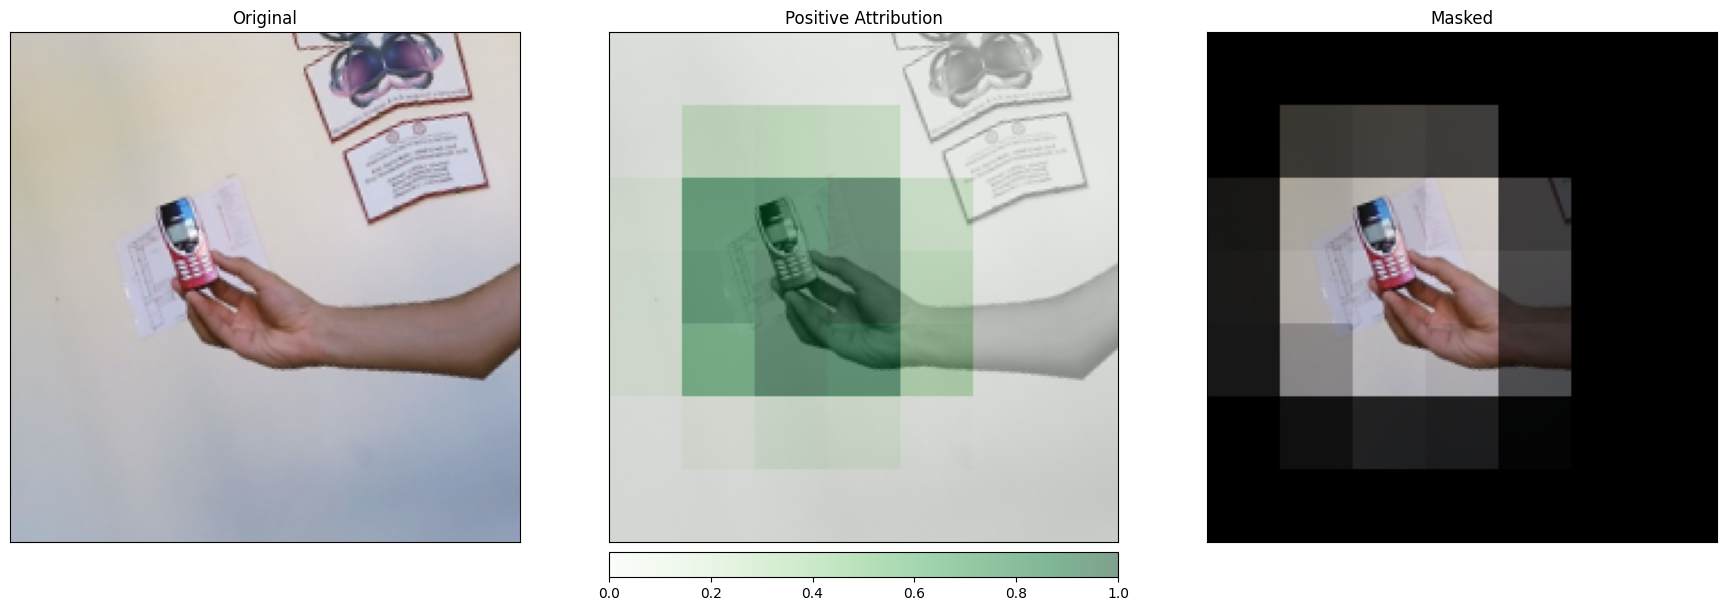

In [ ]:
XAI(dataset_resnet,450,train=True)#21socke6#0#196

## Creating File Submission for the 1° Approach

In [ ]:
ls_image=[]
ls_class=[]
for idx in range(test_dataset.__len__()):
    inputs,name_file = test_dataset[idx]

    # put the model in evaluation mode
    model_resnet.eval()
    with torch.no_grad():
        inputs=inputs.to(device)
        outputs = model_resnet(inputs.unsqueeze(0))
    _, preds = torch.max(outputs, 1)
    
    ls_image.append(name_file)
    ls_class.append(int(preds.cpu()))
    #print("file: "+str(file)+" preds: "+str(preds))
    
import pandas as pd

d = {'image': ls_image, 'class': ls_class}
df_resnet = pd.DataFrame(data=d)

df_resnet.to_csv("submission_resnet.csv",index=False)

# I GOT 90.5% Accuracy with this method


In [ ]:
df_resnet.head(11)

image  class
0   000.jpg      3
1   001.jpg      0
2   002.jpg      3
3   003.jpg      4
4   004.jpg      0
5   005.jpg      5
6   006.jpg      0
7   007.jpg      7
8   008.jpg      0
9   009.jpg      2
10  010.jpg      5

# Object Detection Approach

## Data Augmentations

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(1),
        A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2, rotate_limit=45, p=0.5),        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

 # Data Loader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
dataset = UnictImg(dest_dir, train=True,res_bb_perc=0.05,transforms= get_train_transform())

train_data_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


class 3
Area = tensor(12544)


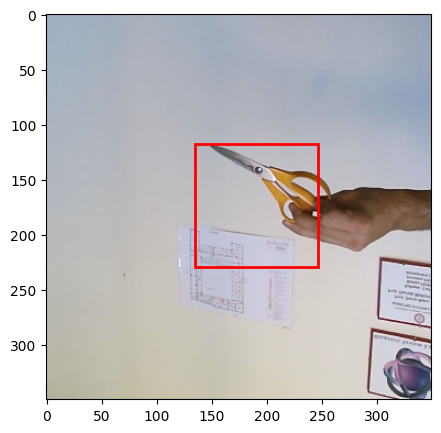

In [ ]:
img, target,idx = dataset[500]
print('class '+str(idx))
bb=target['boxes'][0]
print('Area = '+str((bb[2]-bb[0])*(bb[3]-bb[1])))
img=torch_to_pil(img)
plot_img_bbox(img, target)

## Defining Model Faster R-CNN

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 9 # 8 Classes + 1 background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 77.0MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction


## Setting HyperParameters Model

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0001)
lr_scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

## Training the Model

In [ ]:
num_epochs =  7 #Low epoch to save GPU time
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []
true_lab=[]
start = time.time()
for epoch in range(num_epochs):
    loss_hist.reset()
    model.train()
    for images, targets,idx in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)  
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")
    
    #evaluation
    
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Iteration #50 loss: 0.2757723331451416
Iteration #100 loss: 0.2368464469909668
Iteration #150 loss: 0.21443918347358704
Iteration #200 loss: 0.20964863896369934
Epoch #0 loss: 0.28306635953485965
Iteration #250 loss: 0.14696086943149567
Iteration #300 loss: 0.1787598580121994
Iteration #350 loss: 0.15496930480003357
Iteration #400 loss: 0.12963581085205078
Epoch #1 loss: 0.1683945469558239
Iteration #450 loss: 0.12784230709075928
Iteration #500 loss: 0.11383167654275894
Iteration #550 loss: 0.12804128229618073
Iteration #600 loss: 0.09524250030517578
Epoch #2 loss: 0.1367374738678336
Iteration #650 loss: 0.0801488608121872
Iteration #700 loss: 0.11170980334281921
Iteration #750 loss: 0.10078873485326767
Iteration #800 loss: 0.09896133095026016
Epoch #3 loss: 0.11579478763043881
Iteration #850 loss: 0.07973647862672806
Iteration #900 loss: 0.08187643438577652
Iteration #950 loss: 0.10314441472291946
Iteration #1000 loss: 0.1026361733675003
Epoch #4 loss: 0.09320006404072047
Iteration #1

## Testing model with Training Data

predicted #boxes:  {'boxes': tensor([[274.3978,  72.1174, 349.9278, 180.1816],
        [277.6566,  52.2861, 346.1093, 170.8581],
        [272.2220,  69.4556, 348.8936, 194.6779],
        [279.3842,  67.0430, 350.0000, 131.5863],
        [268.5144,  29.7257, 349.5423, 145.1931]], device='cuda:0'), 'labels': tensor([5, 4, 2, 5, 5], device='cuda:0'), 'scores': tensor([0.7365, 0.1935, 0.0995, 0.0909, 0.0615], device='cuda:0')}
real #boxes:  tensor([5])
EXPECTED OUTPUT


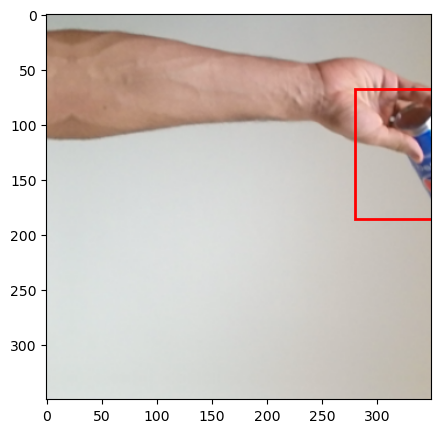

tensor([5])
MODEL OUTPUT


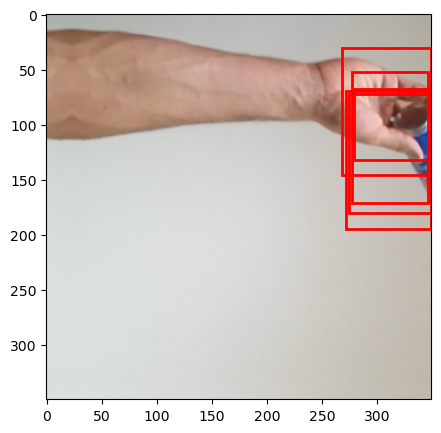

tensor([5, 4, 2, 5, 5], device='cuda:0')
NMS APPLIED MODEL OUTPUT


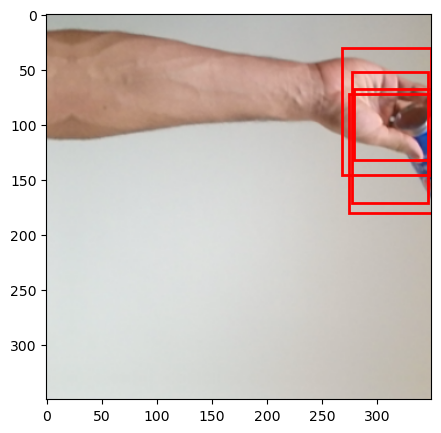

5


In [ ]:

# pick one image from the test set
img, target = dataset[800]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', prediction)
print('real #boxes: ', target['labels'])

print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)
print(target['labels'])
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)
print(prediction['labels'])
nms_prediction = apply_nms(prediction, iou_thresh=0.8)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)
print(nms_prediction['labels'].cpu().numpy()[0])

## Testing model with Test Data

In [ ]:
test_dataset = UnictImg(dest_dir, train=False, transforms= get_test_transform())

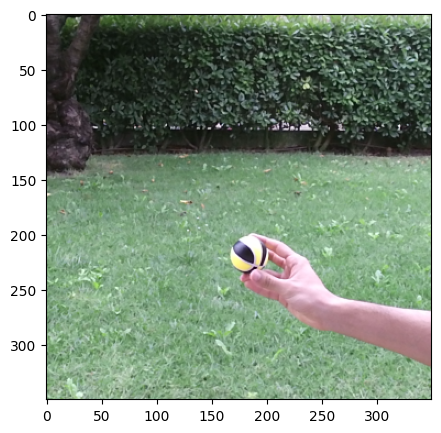

015.jpg
predicted #boxes:  {'boxes': tensor([[155.7993, 178.5755, 270.3860, 291.7677]], device='cuda:0'), 'labels': tensor([7], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}
EXPECTED OUTPUT


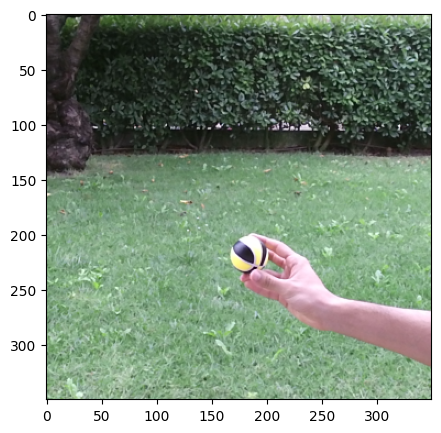

MODEL OUTPUT


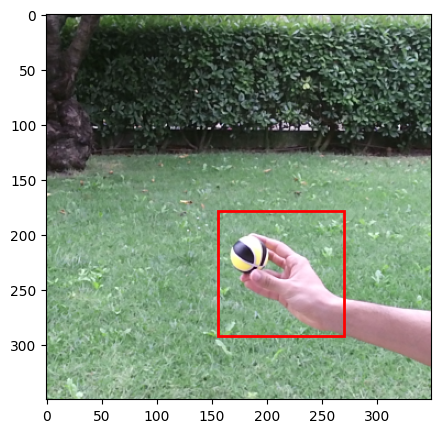

tensor([7], device='cuda:0')
NMS APPLIED MODEL OUTPUT


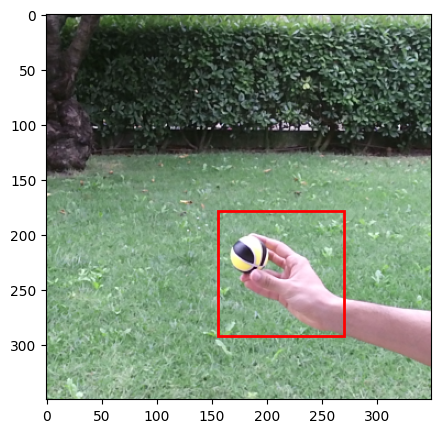

7


In [ ]:
img,name_file = test_dataset[15]
plot_img_bbox(torch_to_pil(img), train=False)

print(name_file)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', prediction)


print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), train=False)
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)
print(prediction['labels'])
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)
print(nms_prediction['labels'].cpu().numpy()[0])

## Creating Submission.csv File

In [ ]:
ls_image=[]
ls_class=[]
for idx in range(test_dataset.__len__()):
    img,name_file = test_dataset[idx]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    nms_prediction = apply_nms(prediction, iou_thresh=0.5)
    pred=nms_prediction['labels'].cpu().numpy()[0]
    
    ls_image.append(name_file)
    ls_class.append(pred-1)
    #print("file: "+str(file)+" preds: "+str(preds))
    
import pandas as pd

d = {'image': ls_image, 'class': ls_class}
df = pd.DataFrame(data=d)
df.to_csv("submission_fastercnn.csv",index=False)

In [ ]:
df.head()

image  class
0  000.jpg      3
1  001.jpg      0
2  002.jpg      3
3  003.jpg      4
4  004.jpg      0